## Pneumonia Detection from Chest X-Rays using CNN

This project focuses on classifying chest X-ray images to detect signs of pneumonia.    

The dataset used in this project is the **Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images (Version 3)**, available on Mendeley Data:

- [(OCT) and Chest X-Ray Images on Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/3)

> **Note:** The dataset zip file contains two folders: `OCT` and `Chest X-Ray`. In this project, we use only the `Chest X-Ray` folder.

> **Note:** The original Chest X-Ray folder contains `train` and `test` subfolders, each with `NORMAL` and `PNEUMONIA` classes.  
> Due to class imbalance, all `NORMAL` and `PNEUMONIA` images were combined into two main folders to allow for stratified splitting, resulting in the following structure:

```css
chest_xray/
├─ NORMAL/
└─ PNEUMONIA/
```

---

### Project Overview

**1. Dataset**
- Contains chest X-ray images labeled as either *Normal* or *Pneumonia*.  
- Stratified splitting was used to ensure balanced train, validation, and test sets due to class imbalance.

**2. Model**
- A custom Convolutional Neural Network (CNN) was designed for the classification task.

**3. Training**
- Data augmentation was applied to training images.  
- Optimization was performed using **AdamW** with weight decay.  
- The model was trained for up to 20 epochs, with the best weights selected based on validation accuracy.

**4. Evaluation**
- Model performance was measured on the test set using accuracy, confusion matrix, and classification report.  
- Learning curves were plotted to visualize training and validation loss and accuracy.

---

### 1. Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os
from PIL import Image

### 2. Configuration

In [2]:
# Fixing a random seed for consistent results
RANDOM_SEED = 42

# Dataset path and class labels
DATA_DIR = "chest_xray"
classes = ["NORMAL", "PNEUMONIA"]

# Training hyperparameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Device config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3. Seed Function

This function ensures reproducibility across Python, NumPy and PyTorch, making this experiment more consistent.

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(RANDOM_SEED)

### 4. Dataset Distribution Plot

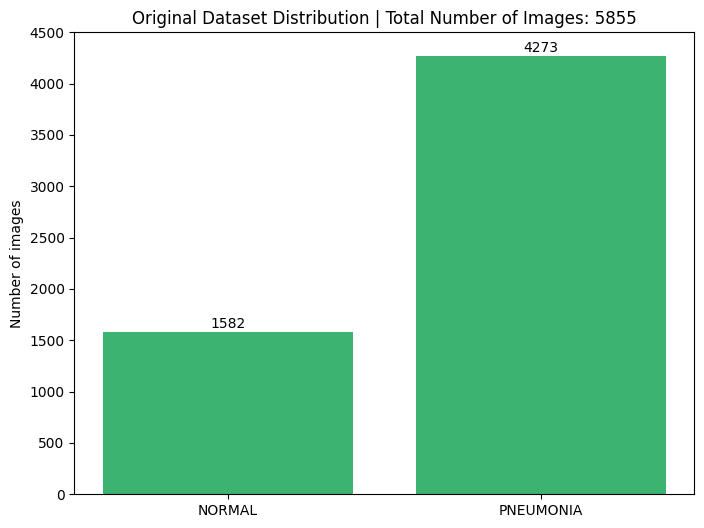

In [4]:
def get_dataset_stats(dataset_path):
    class_counts = {cls: 0 for cls in classes}
    
    for cls in os.listdir(dataset_path):
        cls_path = os.path.join(dataset_path, cls)
        if os.path.isdir(cls_path):
            img_files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            class_counts[cls] = len(img_files)
    return class_counts

def plot_class_distribution(class_counts, title):
    total_images = sum(class_counts.values())
    plt.figure(figsize=(8,6))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color='mediumseagreen')
    
    plt.title(f"{title} | Total Number of Images: {total_images}", fontsize=12)
    plt.ylim(0, 4500)
    plt.ylabel("Number of images")
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 10, f"{int(height)}", ha='center', va='bottom', fontsize=10)
    
    plt.show()

# Show original dataset distribution
original_counts = get_dataset_stats(DATA_DIR)
plot_class_distribution(original_counts, "Original Dataset Distribution")

### 5. Data Transforms

Transformations applied to **training** images with augmentation; **validation** and **test** images with no augmentation.

In [5]:
# Transformations applied to training images
train_transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
])

# Transformations applied to validation and test images
val_test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

### 6. Custom CNN Model

In [6]:
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # First convolutional block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # Reduce spatial dimentions by half
        )

        # Second convolutional block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # Reduce spatial dimentions by half
        )
        
        # Third convolutional block
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # Reduce spatial dimentions by half
        )
        
        # Flatten layer to convert 3D feature maps to 1D vector
        self.flatten = nn.Flatten()
        
        # Dynamically compute feature size
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 224, 224)  # 1 grayscale image
            out = self.conv_block1(dummy)
            out = self.conv_block2(out)
            out = self.conv_block3(out)
            flattened_size = out.numel()
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(in_features=flattened_size, out_features=512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(in_features=128, out_features=2) # 2 output classes: Normal and Pneumonia
        
    def forward(self, x):
        # Conv blocks
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        # Flatten
        x = self.flatten(x)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        logits = self.fc3(x)

        return logits

### 7. Prepare Stratified Train/Val/Test Split

Here, we are using `StratifiedShuffleSplit` to ensure that each subset (train, val, test) keeps the same class proportions as the full dataset, which is important in imbalanced datasets.

In [7]:
# Build mapping
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Collect all image paths and labels
image_paths, labels = [], []
for cls in classes:
    cls_idx = class_to_idx[cls]
    cls_dir = os.path.join(DATA_DIR, cls)
    for img_file in os.listdir(cls_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(cls_dir, img_file))
            labels.append(cls_idx)

# Stratified splitting
# First split: Train (80%) & Temp (20%)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
train_idx, temp_idx = next(sss.split(image_paths, labels))

# Second split: Temp (20%) = Validation (10%) + Test (10%)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_SEED)
val_idx, test_idx = next(sss_val.split([image_paths[i] for i in temp_idx], [labels[i] for i in temp_idx]))

# Custom ChestXrayDataset Dataset class
class ChestXrayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Create dataset objects
train_dataset = ChestXrayDataset([image_paths[i] for i in train_idx],
                                 [labels[i] for i in train_idx],
                                 transform=train_transform)

val_dataset = ChestXrayDataset([image_paths[temp_idx[i]] for i in val_idx],
                               [labels[temp_idx[i]] for i in val_idx],
                               transform=val_test_transform)

test_dataset = ChestXrayDataset([image_paths[temp_idx[i]] for i in test_idx],
                                [labels[temp_idx[i]] for i in test_idx],
                                transform=val_test_transform)

# Wrap in DataLoader
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True),
    "val": DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True),
    "test": DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
}

### 8. Training Loop

In [8]:
def train_model(model, optimizer, criterion, num_epochs=20):
    
    best_acc = 0.0  # Track best validation accuracy
    best_model_wts = model.state_dict()  # Save best model weights
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, corrects = 0.0, 0

        # --- TRAINING LOOP ---
        for inputs, labels in dataloaders["train"]:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels)

        train_loss /= len(dataloaders["train"].dataset)
        train_acc = corrects.double() / len(dataloaders["train"].dataset)

        # --- VALIDATION LOOP ---
        model.eval()
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in dataloaders["val"]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels)

        val_loss /= len(dataloaders["val"].dataset)
        val_acc = val_corrects.double() / len(dataloaders["val"].dataset)

        # Save history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc.item())
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

### 9. Evaluation Function

In [9]:
def evaluate_model(model):
    model.eval() # Set model to evaluation mode
    y_true, y_pred = [], []
    
    # Collect predictions
    with torch.no_grad():
        for inputs, labels in dataloaders["test"]:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Make sure we only report on classes that actually appear
    unique_labels = sorted(set(y_true) | set(y_pred))

    # Classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=[classes[i] for i in unique_labels], zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(10,8))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=[classes[i] for i in unique_labels],
        yticklabels=[classes[i] for i in unique_labels],
        cmap="crest"
    )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

    return y_true, y_pred

### 10. Train and Evaluate Model


=== Training Custom CNN Model ===
Epoch 1/20 | Train Loss: 0.4442, Train Acc: 0.8305, Val Loss: 0.1472, Val Acc: 0.9487
Epoch 2/20 | Train Loss: 0.2130, Train Acc: 0.9120, Val Loss: 0.1198, Val Acc: 0.9573
Epoch 3/20 | Train Loss: 0.1777, Train Acc: 0.9317, Val Loss: 0.1219, Val Acc: 0.9521
Epoch 4/20 | Train Loss: 0.1650, Train Acc: 0.9351, Val Loss: 0.1307, Val Acc: 0.9607
Epoch 5/20 | Train Loss: 0.1553, Train Acc: 0.9413, Val Loss: 0.0836, Val Acc: 0.9709
Epoch 6/20 | Train Loss: 0.1499, Train Acc: 0.9464, Val Loss: 0.1115, Val Acc: 0.9573
Epoch 7/20 | Train Loss: 0.1397, Train Acc: 0.9477, Val Loss: 0.0873, Val Acc: 0.9675
Epoch 8/20 | Train Loss: 0.1455, Train Acc: 0.9468, Val Loss: 0.0883, Val Acc: 0.9709
Epoch 9/20 | Train Loss: 0.1428, Train Acc: 0.9481, Val Loss: 0.0985, Val Acc: 0.9658
Epoch 10/20 | Train Loss: 0.1242, Train Acc: 0.9552, Val Loss: 0.0861, Val Acc: 0.9658
Epoch 11/20 | Train Loss: 0.1216, Train Acc: 0.9547, Val Loss: 0.0938, Val Acc: 0.9692
Epoch 12/20 | Tra

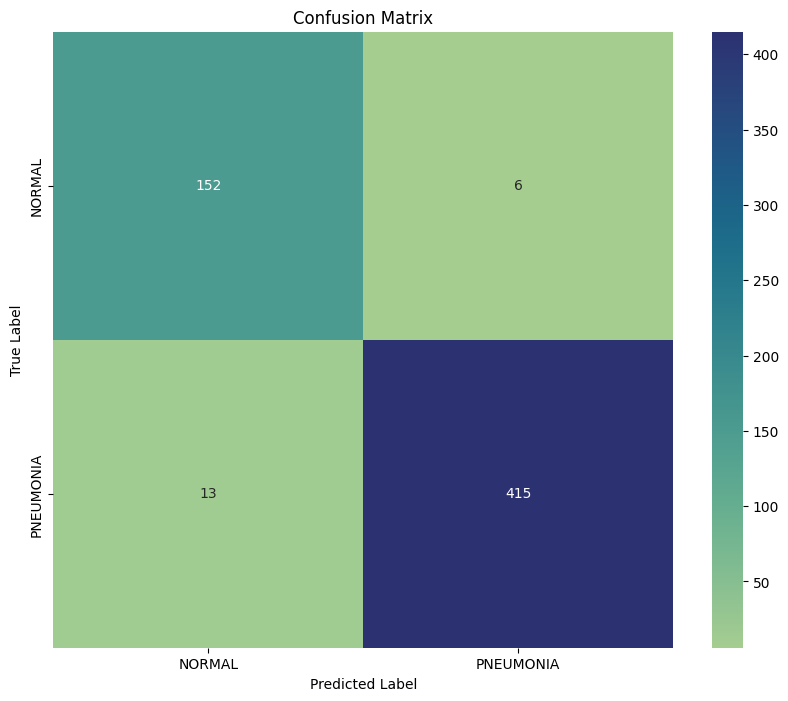

In [10]:
model = PneumoniaCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)

NUM_EPOCHS = 20

print("\n=== Training Custom CNN Model ===")
# Train model
model, history = train_model(model, optimizer, criterion, num_epochs=NUM_EPOCHS)

# Evaluate model on test set
print("\n=== Evaluation ===")
y_true, y_pred = evaluate_model(model)

# Compute overall test accuracy
final_accuracy = sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

### 11. Plot Learning Curve

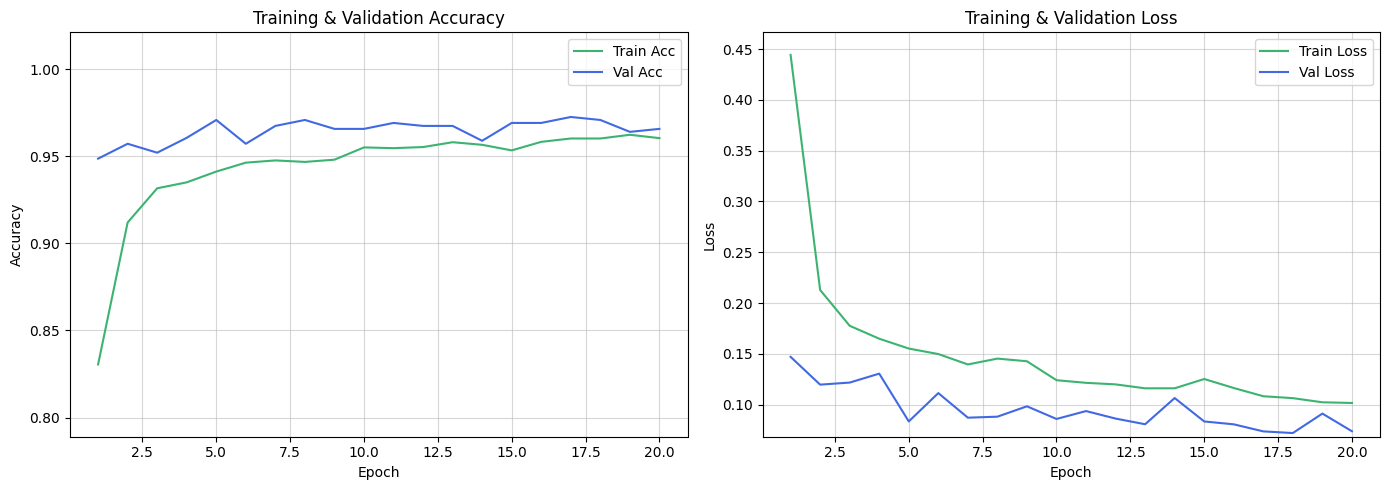

In [11]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # --- Accuracy subplot ---
    axs[0].plot(epochs, history['train_acc'], label='Train Acc', color='mediumseagreen')
    axs[0].plot(epochs, history['val_acc'], label='Val Acc', color='royalblue')
    axs[0].set_title("Training & Validation Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    axs[0].grid(True, alpha=0.5)
    axs[0].set_ylim(min(min(history['train_acc']), min(history['val_acc'])) * 0.95,
                    max(max(history['train_acc']), max(history['val_acc'])) * 1.05)

    # --- Loss subplot ---
    axs[1].plot(epochs, history['train_loss'], label='Train Loss', color='mediumseagreen')
    axs[1].plot(epochs, history['val_loss'], label='Val Loss', color='royalblue')
    axs[1].set_title("Training & Validation Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    axs[1].grid(True, alpha=0.5)
    axs[1].set_ylim(min(min(history['train_loss']), min(history['val_loss'])) * 0.95,
                    max(max(history['train_loss']), max(history['val_loss'])) * 1.05)

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

### 12. Final Accuracy Bar Plot

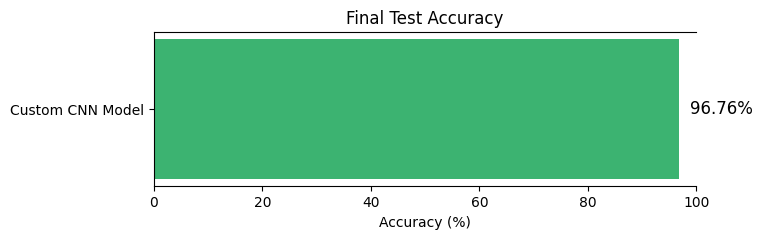

In [12]:
final_acc_percent = final_accuracy * 100

plt.figure(figsize=(7,2))
plt.barh(["Custom CNN Model"], [final_acc_percent], color="mediumseagreen")
plt.gca().spines['right'].set_visible(False)
plt.xlim(0, 100)
plt.xlabel("Accuracy (%)")
plt.title("Final Test Accuracy")
plt.text(final_acc_percent + 2, 0, f"{final_acc_percent:.2f}%", va='center', fontsize=12)
plt.show()